In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx
import igraph as ig
import leidenalg as la

In [13]:
lines = gpd.read_file("../edges_january.gpkg").rename(columns={'focal': 'src',
                                                               'target': 'trg',
                                                               'weight': 'nij'})

edges = lines[['src', 'trg', 'nij']]

In [53]:
edges = edges[edges.nij > 10]

In [101]:
df = disparity_filter(edges)
nc = noise_corrected(edges)
st = maximum_spanning_tree(edges)

Calculating DF score...
Calculating NC score...
Calculating MST score...


In [102]:
print(df.shape)
print(nc.shape)
print(st.shape)

(145430, 5)
(145430, 5)
(2379, 4)


In [56]:
print(edges.shape)

(148772, 3)


In [103]:
df = thresholding(df, 0.0001)
nc = thresholding(nc, 0.0001)
st = thresholding(st, 0.05)

In [104]:
print(df.shape)
print(nc.shape)
print(st.shape)

(145368, 4)
(140829, 4)
(2379, 4)


In [105]:
df['od'] = df['src'] + " " + df['trg'] 
nc['od'] = nc['src'] + " " + nc['trg'] 
st['od'] = st['src'] + " " + st['trg']

lines['od'] = lines['src'] + " " + lines['trg'] 

In [81]:
import cenpy

acs = cenpy.remote.APIConnection("ACSDT5Y2018")
acs.set_mapservice("tigerWMS_ACS2018")

Connection to American Community Survey: 5-Year Estimates: Detailed Tables 5-Year(ID: https://api.census.gov/data/id/ACSDT5Y2018)
With MapServer: Census ACS 2018 WMS

In [82]:
metros = pd.read_csv("../data/metrolist_one.csv", nrows=1159, header=None)
metros = metros.set_axis(['metro_fips', 'metro_name', 'county_fips', 'county_name'], axis=1)

bay = metros[(metros.metro_name.str.contains('San Jose')) | (metros.metro_name.str.contains('San Francisco'))]
bay = bay[bay.county_name!="San Benito, CA"]

bay.head()

,metro_fips,metro_name,county_fips,county_name
963,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6001,"Alameda, CA"
964,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6013,"Contra Costa, CA"
965,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6041,"Marin, CA"
966,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6075,"San Francisco, CA"
967,41860,"San Francisco-Oakland-Berkeley, CA (Metropolit...",6081,"San Mateo, CA"


In [83]:
def get_nodes(fips):
    
    state = fips[:2]
    county = fips[2:]
        
    where_clause = f"STATE = {state} AND COUNTY = {county}"
    block_groups = acs.mapservice.layers[10].query(where=where_clause)
    
    block_groups = block_groups.to_crs(3857)
    
    nodes = pd.DataFrame({'X': block_groups.centroid.x,
                          'Y': block_groups.centroid.y,
                          'geometry': block_groups.geometry,
                          'cbg': block_groups.GEOID.astype('int64')}).set_index('cbg')
    
    return nodes

In [84]:
nodes = list()
shape = list()

for fips in bay.county_fips:
    
    fips = "0" + str(fips)
    
    current = get_nodes(fips)
    feature = current.geometry
    
    shape.append(feature)
    nodes.append(current.drop('geometry', axis=1))

nodes = pd.concat(nodes, ignore_index=False)
shape = gpd.GeoDataFrame(pd.concat(shape, ignore_index=False))

/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/andrewrenninger/anaconda3/envs/tinkering/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When maki

In [87]:
water = list()

for fips in bay.county_fips:
    
    fips = "0" + str(fips)
    
    year = 2018
    
    sfips = fips[:2]
    cfips = fips[2:]
    
    url = f"https://www2.census.gov/geo/tiger/TIGER{year}/AREAWATER/tl_{year}_{sfips}{cfips}_areawater.zip"
    
    water.append(gpd.read_file(url))

water = gpd.GeoDataFrame(pd.concat(water, ignore_index=True))

In [96]:
water = water.to_crs(3857)

water_dissolved = water.dissolve()
shape_dissolved = shape.dissolve()
background = shape_dissolved['geometry'].difference(water_dissolved['geometry'])

In [97]:
lines = lines.to_crs(3857)

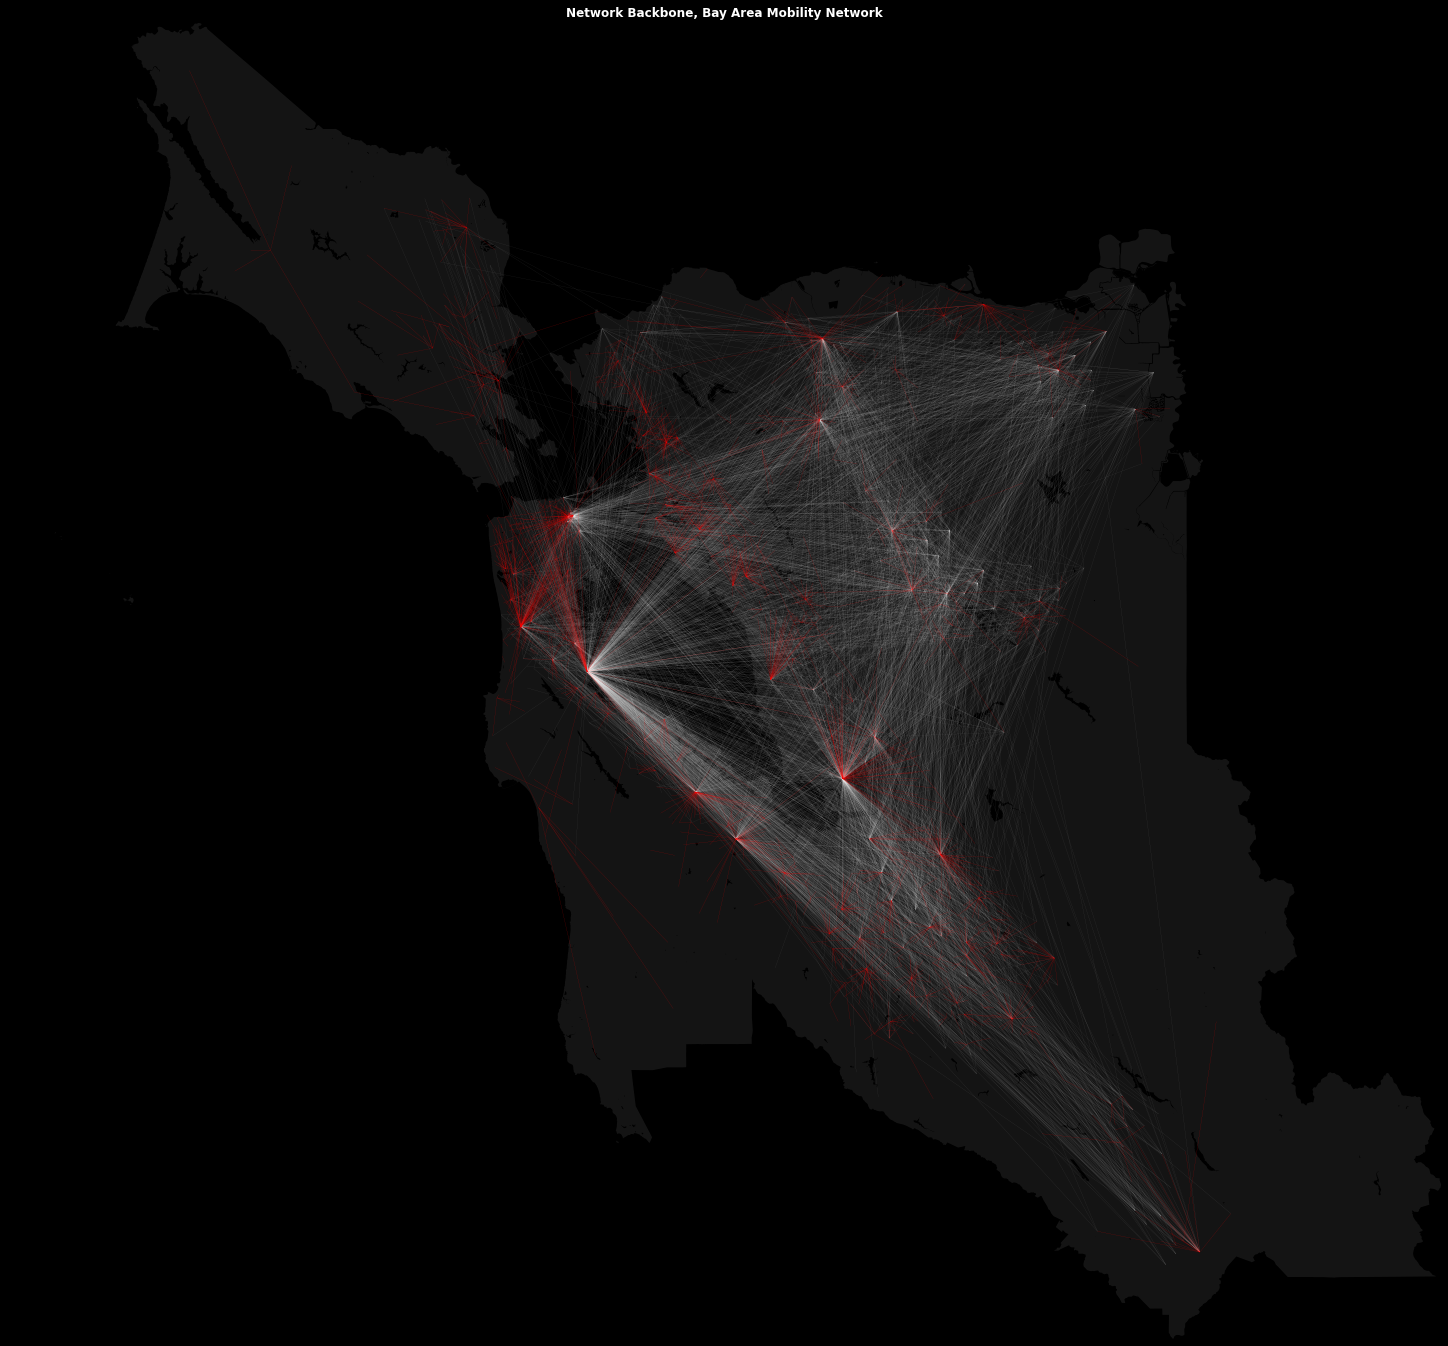

In [107]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(20, 20), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

background.plot(color='dimgray', ax=ax, linewidth=0.5, alpha=0.2)

lines[lines.od.isin(df.od)].plot(color='white', ax=ax, linewidth=0.01, alpha=0.2)
lines[lines.od.isin(df.od) & ~lines.od.isin(nc.od)].plot(color='white', ax=ax, linewidth=0.05, alpha=0.6)
lines[lines.od.isin(st.od)].plot(color='red', ax=ax, linewidth=0.1, alpha=1)

ax.set_title("Network Backbone, Bay Area Mobility Network", color='white', weight='bold')
ax.margins(0)
ax.axis('off')

fig.savefig('backbone_noisecorrected.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

In [175]:
edges['lognij'] = np.log(edges.nij)

agg_d = edges[['src', 'lognij']].groupby(['src']).agg(['min', 'max', 'mean', 'std'])
agg_o = edges[['trg', 'lognij']].groupby(['trg']).agg(['min', 'max', 'mean', 'std'])

In [176]:
agg_d.columns = ['_d_'.join(i) for i in agg_d.columns]
agg_d = agg_d.reset_index()

agg_o.columns = ['_o_'.join(i) for i in agg_o.columns]
agg_o = agg_o.reset_index()

In [177]:
zscoring = edges.merge(agg_d, left_on='src', 
                       right_on='src', 
                       how='left').merge(agg_o, left_on='trg', 
                                         right_on='trg', 
                                         how='left')

zscoring['zscore_d'] =  (zscoring['lognij'] - zscoring['lognij_d_mean']) / zscoring['lognij_d_std']
zscoring['zscore_o'] =  (zscoring['lognij'] - zscoring['lognij_o_mean']) / zscoring['lognij_o_std']

zscoring = zscoring[['src', 'trg', 'nij', 'lognij', 'zscore_d', 'zscore_o', 'lognij_d_std', 'lognij_o_std']]

zscoring.head()

,src,trg,nij,lognij,zscore_d,zscore_o,lognij_d_std,lognij_o_std
0,060014226001,060014225002,148.0,4.997212,2.520614,2.896718,0.773976,0.641836
1,060014226001,060014228001,747.0,6.616065,4.612220,2.779662,0.773976,1.151655
2,060014226001,060014226001,291.0,5.673323,3.394170,2.390871,0.773976,0.978495
3,060014226001,060014228003,375.0,5.926926,3.721832,2.739566,0.773976,0.957809
4,060014226001,060014228002,420.0,6.040255,3.868256,2.241135,0.773976,1.149420


In [186]:
cuts = list()

for i in np.arange(1.5, 3.5, 0.5):
    
    print(i)
    
    temp = zscoring[zscoring.zscore_d > (zscoring.lognij_d_std * i)]
    temp['threshold'] = np.tile(i, temp.shape[0])
    
    cuts.append(temp)
    
cuts = pd.concat(cuts, ignore_index=True)

1.5
2.0
2.5
3.0


/var/folders/b6/h942qzzd5f721pfd0b3d411m0000gn/T/ipykernel_94320/2605011659.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['threshold'] = np.tile(i, temp.shape[0])


0
1
2
3


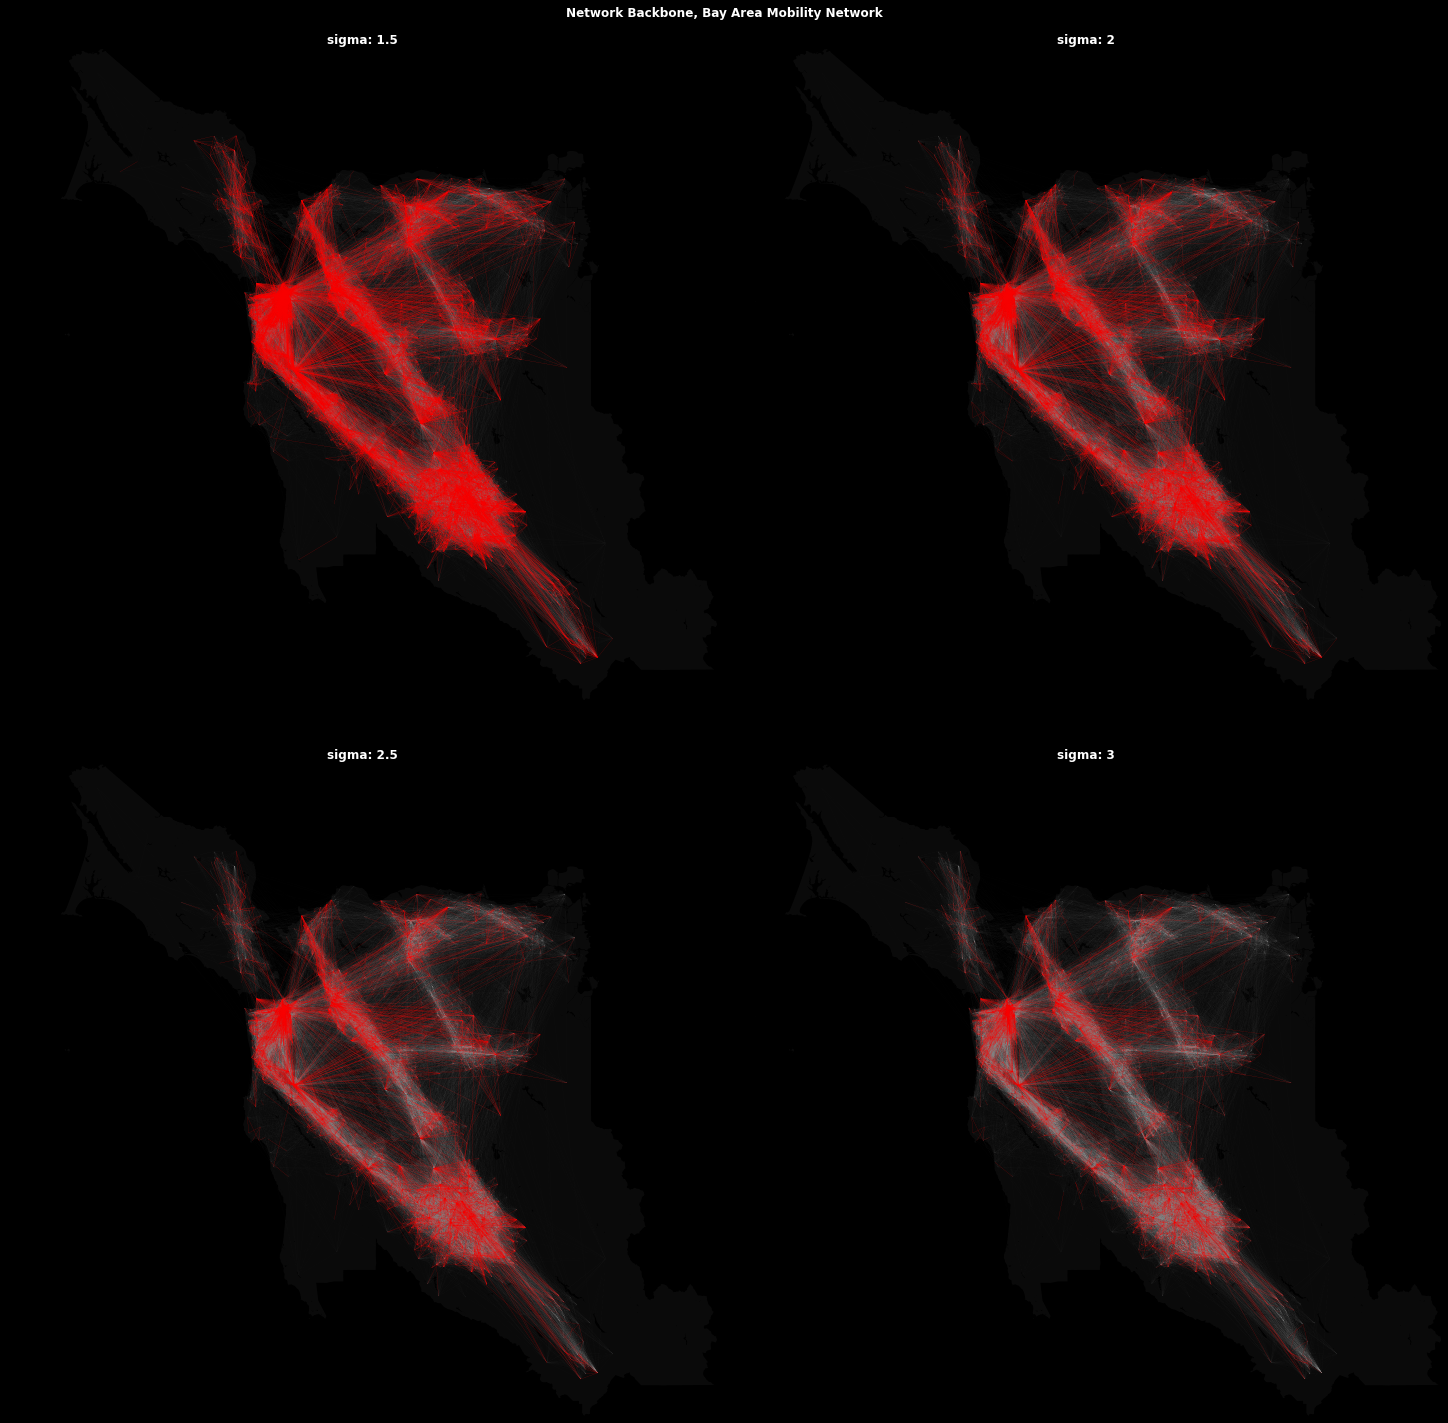

In [187]:
import matplotlib.pyplot as plt

cuts['od'] = cuts['src'] + " " + cuts['trg']
thresholds = [1.5, 2, 2.5, 3]

fig, axs = plt.subplots(2, 2, figsize=(20, 20), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

axs = axs.ravel()

for i in np.arange(0, 4):
    
    print(i)
    
    temp = cuts[cuts.threshold==thresholds[i]]
    
    background.plot(color='dimgray', ax=axs[i], alpha=0.1)
    lines[lines.od.isin(df.od)].plot(color='white', ax=axs[i], linewidth=0.01, alpha=0.5)
    lines[lines.od.isin(temp.od)].plot(color='red', ax=axs[i], linewidth=0.1, alpha=1)

    axs[i].margins(0)
    axs[i].axis('off')
    
    axs[i].set_title(f"sigma: {thresholds[i]}", color='w', weight='bold')

    
fig.suptitle("Network Backbone, Bay Area Mobility Network", color='white', weight='bold')
fig.savefig('backbone_zscore.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')

In [112]:
import sys

def thresholding(table, threshold):
    """Reads a preprocessed edge table and returns only the edges supassing a significance threshold.

    Args:
    table (pandas.DataFrame): The edge table.
    threshold (float): The minimum significance to include the edge in the backbone.

    Returns:
    The network backbone.
    """
    table = table.copy()
    if "sdev_cij" in table:
        return table[(table["score"] - (threshold * table["sdev_cij"])) > 0][["src", "trg", "nij", "score"]]
    else:
        return table[table["score"] > threshold][["src", "trg", "nij", "score"]]

def write(table, network, method, folder):
    if not table.empty and "src" in table:
        table.to_csv("%s/%s_%s.csv" % (folder, network, method), sep = "\t", index = False)
    else:
        warnings.warn("Incorrect/empty output. Nothing written on disk", RuntimeWarning)

def stability_jac(table1, table2):
    table1_edges = set(zip(table1["src"], table1["trg"]))
    table2_edges = set(zip(table2["src"], table2["trg"]))
    return float(len(table1_edges & table2_edges)) / len(table1_edges | table2_edges)

def stability_corr(table1, table2, method = "spearman", log = False, what = "nij"):
    corr_table = table1.merge(table2, on = ["src", "trg"])
    corr_table = corr_table[["%s_x" % what, "%s_y" % what]]
    if log:
        corr_table["%s_x" % what] = np.log(corr_table["%s_x" % what])
        corr_table["%s_y" % what] = np.log(corr_table["%s_y" % what])
    return corr_table["%s_x" % what].corr(corr_table["%s_y" % what], method = method)

def test_densities(table, start, end, step):
    if start > end: 
        raise ValueError("start must be lower than end")
    steps = []
    x = start
    while x <= end:
        steps.append(x)
        x += step
    onodes = len(set(table["src"]) | set(table["trg"]))
    oedges = table.shape[0]
    oavgdeg = (2.0 * oedges) / onodes
    for s in steps: 
        edge_table = thresholding(table, s)
        nodes = len(set(edge_table["src"]) | set(edge_table["trg"]))
        edges = edge_table.shape[0]
        avgdeg = (2.0 * edges) / nodes
        yield (s, nodes, (100.0 * nodes) / onodes, edges, (100.0 * edges) / oedges, avgdeg, avgdeg / oavgdeg)

def noise_corrected(table, undirected = False, return_self_loops = False, calculate_p_value = False):
    sys.stderr.write("Calculating NC score...\n")
    table = table.copy()
    src_sum = table.groupby(by = "src").sum()[["nij"]]
    table = table.merge(src_sum, left_on = "src", right_index = True, suffixes = ("", "_src_sum"))
    trg_sum = table.groupby(by = "trg").sum()[["nij"]]
    table = table.merge(trg_sum, left_on = "trg", right_index = True, suffixes = ("", "_trg_sum"))
    table.rename(columns = {"nij_src_sum": "ni.", "nij_trg_sum": "n.j"}, inplace = True)
    table["n.."] = table["nij"].sum()
    table["mean_prior_probability"] = ((table["ni."] * table["n.j"]) / table["n.."]) * (1 / table["n.."])
    if calculate_p_value:
        table["score"] = scipy.stats.binom.cdf(table["nij"], table["n.."], table["mean_prior_probability"])
        return table[["src", "trg", "nij", "score"]]
    table["kappa"] = table["n.."] / (table["ni."] * table["n.j"])
    table["score"] = ((table["kappa"] * table["nij"]) - 1) / ((table["kappa"] * table["nij"]) + 1)
    table["var_prior_probability"] = (1 / (table["n.."] ** 2)) * (table["ni."] * table["n.j"] * (table["n.."] - table["ni."]) * (table["n.."] - table["n.j"])) / ((table["n.."] ** 2) * ((table["n.."] - 1)))
    table["alpha_prior"] = (((table["mean_prior_probability"] ** 2) / table["var_prior_probability"]) * (1 - table["mean_prior_probability"])) - table["mean_prior_probability"]
    table["beta_prior"] = (table["mean_prior_probability"] / table["var_prior_probability"]) * (1 - (table["mean_prior_probability"] ** 2)) - (1 - table["mean_prior_probability"])
    table["alpha_post"] = table["alpha_prior"] + table["nij"]
    table["beta_post"] = table["n.."] - table["nij"] + table["beta_prior"]
    table["expected_pij"] = table["alpha_post"] / (table["alpha_post"] + table["beta_post"])
    table["variance_nij"] = table["expected_pij"] * (1 - table["expected_pij"]) * table["n.."]
    table["d"] = (1.0 / (table["ni."] * table["n.j"])) - (table["n.."] * ((table["ni."] + table["n.j"]) / ((table["ni."] * table["n.j"]) ** 2)))
    table["variance_cij"] = table["variance_nij"] * (((2 * (table["kappa"] + (table["nij"] * table["d"]))) / (((table["kappa"] * table["nij"]) + 1) ** 2)) ** 2) 
    table["sdev_cij"] = table["variance_cij"] ** .5
    if not return_self_loops:
        table = table[table["src"] != table["trg"]]
    if undirected:
        table = table[table["src"] <= table["trg"]]
    return table[["src", "trg", "nij", "score", "sdev_cij"]]

def doubly_stochastic(table, undirected = False, return_self_loops = False):
    sys.stderr.write("Calculating DST score...\n")
    table = table.copy()
    table2 = table.copy()
    original_nodes = len(set(table["src"]) | set(table["trg"]))
    table = pd.pivot_table(table, values = "nij", index = "src", columns = "trg", aggfunc = "sum", fill_value = 0) + .001
    row_sums = table.sum(axis = 1)
    attempts = 0
    while np.std(row_sums) > 1e-12:
        table = table.div(row_sums, axis = 0)
        col_sums = table.sum(axis = 0)
        table = table.div(col_sums, axis = 1)
        row_sums = table.sum(axis = 1)
        attempts += 1
        if attempts > 1000:
            warnings.warn("Matrix could not be reduced to doubly stochastic. See Sec. 3 of Sinkhorn 1964", RuntimeWarning)
            return pd.DataFrame()
    table = pd.melt(table.reset_index(), id_vars = "src")
    table = table[table["src"] < table["trg"]]
    table = table[table["value"] > 0].sort_values(by = "value", ascending = False)
    i = 0
    if undirected:
        G = nx.Graph()
        while nx.number_connected_components(G) != 1 or nx.number_of_nodes(G) < original_nodes:
            edge = table.iloc[i]
            G.add_edge(edge["src"], edge["trg"], weight = edge["value"])
            i += 1
    else:
        G = nx.DiGraph()
        while nx.number_weakly_connected_components(G) != 1 or nx.number_of_nodes(G) < original_nodes:
            edge = table.iloc[i]
            G.add_edge(edge["src"], edge["trg"], weight = edge["value"])
            i += 1
    table = pd.melt(nx.to_pandas_adjacency(G).reset_index(), id_vars = "index")
    table = table[table["value"] > 0]
    table.rename(columns = {"index": "src", "variable": "trg", "value": "cij"}, inplace = True)
    table["score"] = table["cij"]
    table = table.merge(table2[["src", "trg", "nij"]], on = ["src", "trg"])
    if not return_self_loops:
        table = table[table["src"] != table["trg"]]
    if undirected:
        table = table[table["src"] <= table["trg"]]
    return table[["src", "trg", "nij", "score"]]

def disparity_filter(table, undirected = False, return_self_loops = False):
    sys.stderr.write("Calculating DF score...\n")
    table = table.copy()
    table_sum = table.groupby(table["src"]).sum().reset_index()
    table_deg = table.groupby(table["src"]).count()["trg"].reset_index()
    table = table.merge(table_sum, on = "src", how = "left", suffixes = ("", "_sum"))
    table = table.merge(table_deg, on = "src", how = "left", suffixes = ("", "_count"))
    table["score"] = 1.0 - ((1.0 - (table["nij"] / table["nij_sum"])) ** (table["trg_count"] - 1))
    table["variance"] = (table["trg_count"] ** 2) * (((20 + (4.0 * table["trg_count"])) / ((table["trg_count"] + 1.0) * (table["trg_count"] + 2) * (table["trg_count"] + 3))) - ((4.0) / ((table["trg_count"] + 1.0) ** 2)))
    if not return_self_loops:
        table = table[table["src"] != table["trg"]]
    if undirected:
        table["edge"] = table.apply(lambda x: "%s-%s" % (min(x["src"], x["trg"]), max(x["src"], x["trg"])), axis = 1)
        table_maxscore = table.groupby(by = "edge")["score"].max().reset_index()
        table_minvar = table.groupby(by = "edge")["variance"].min().reset_index()
        table = table.merge(table_maxscore, on = "edge", suffixes = ("_min", ""))
        table = table.merge(table_minvar, on = "edge", suffixes = ("_max", ""))
        table = table.drop_duplicates(subset = ["edge"])
        table = table.drop("edge", 1)
        table = table.drop("score_min", 1)
        table = table.drop("variance_max", 1)
    return table[["src", "trg", "nij", "score", "variance"]]

def high_salience_skeleton(table, undirected = False, return_self_loops = False):
    from collections import defaultdict
    sys.stderr.write("Calculating HSS score...\n")
    table = table.copy()
    table["distance"] = 1.0 / table["nij"]
    nodes = set(table["src"]) | set(table["trg"])
    G = nx.from_pandas_edgelist(table, source = "src", target = "trg", edge_attr = "distance", create_using = nx.DiGraph())
    cs = defaultdict(float)
    for s in nodes:
        pred = defaultdict(list)
        dist = {t: float("inf") for t in nodes}
        dist[s] = 0.0
        Q = defaultdict(list)
        for w in dist:
            Q[dist[w]].append(w)
        S = []
        while len(Q) > 0:
            v = Q[min(Q.keys())].pop(0)
            S.append(v)
            for _, w, l in G.edges(nbunch = [v,], data = True):
                new_distance = dist[v] + l["distance"]
            if dist[w] > new_distance:
                Q[dist[w]].remove(w)
                dist[w] = new_distance
                Q[dist[w]].append(w)
                pred[w] = []
            if dist[w] == new_distance:
                pred[w].append(v)
            while len(S) > 0:
                w = S.pop()
            for v in pred[w]:
                cs[(v, w)] += 1.0
            Q = defaultdict(list, {k: v for k, v in Q.items() if len(v) > 0})
    table["score"] = table.apply(lambda x: cs[(x["src"], x["trg"])] / len(nodes), axis = 1)
    if not return_self_loops:
        table = table[table["src"] != table["trg"]]
    if undirected:
        table["edge"] = table.apply(lambda x: "%s-%s" % (min(x["src"], x["trg"]), max(x["src"], x["trg"])), axis = 1)
        table_maxscore = table.groupby(by = "edge")["score"].sum().reset_index()
        table = table.merge(table_maxscore, on = "edge", suffixes = ("_min", ""))
        table = table.drop_duplicates(subset = ["edge"])
        table = table.drop("edge", 1)
        table = table.drop("score_min", 1)
        table["score"] = table["score"] / 2.0
    return table[["src", "trg", "nij", "score"]]

def naive(table, undirected = False, return_self_loops = False):
    sys.stderr.write("Calculating Naive score...\n")
    table = table.copy()
    table["score"] = table["nij"]
    if not return_self_loops:
        table = table[table["src"] != table["trg"]]
    if undirected:
        table["edge"] = table.apply(lambda x: "%s-%s" % (min(x["src"], x["trg"]), max(x["src"], x["trg"])), axis = 1)
        table_maxscore = table.groupby(by = "edge")["score"].sum().reset_index()
        table = table.merge(table_maxscore, on = "edge", suffixes = ("_min", ""))
        table = table.drop_duplicates(subset = ["edge"])
        table = table.drop("edge", 1)
        table = table.drop("score_min", 1)
        table["score"] = table["score"] / 2.0
    return table[["src", "trg", "nij", "score"]]

def maximum_spanning_tree(table, undirected = False):
    sys.stderr.write("Calculating MST score...\n")
    table = table.copy()
    table["distance"] = 1.0 / table["nij"]
    G = nx.from_pandas_edgelist(table, source = "src", target = "trg", edge_attr = ["distance", "nij"])
    T = nx.minimum_spanning_tree(G, weight = "distance")
    table2 = nx.to_pandas_edgelist(T)
    table2 = table2[table2["nij"] > 0]
    table2.rename(columns = {"source": "src", "target": "trg", "nij": "score"}, inplace = True)
    table = table.merge(table2, on = ["src", "trg"])
    if undirected:
        table["edge"] = table.apply(lambda x: "%s-%s" % (min(x["src"], x["trg"]), max(x["src"], x["trg"])), axis = 1)
        table = table.drop_duplicates(subset = ["edge"])
        table = table.drop("edge", 1)
    return table[["src", "trg", "nij", "score"]]

def minimum_spanning_tree(table, undirected = False):
    sys.stderr.write("Calculating MST score...\n")
    table = table.copy()
    table["distance"] = table["nij"]
    G = nx.from_pandas_edgelist(table, source = "src", target = "trg", edge_attr = ["distance", "nij"])
    T = nx.minimum_spanning_tree(G, weight = "distance")
    table2 = nx.to_pandas_edgelist(T)
    table2 = table2[table2["nij"] > 0]
    table2.rename(columns = {"source": "src", "target": "trg", "nij": "score"}, inplace = True)
    table = table.merge(table2, on = ["src", "trg"])
    if undirected:
        table["edge"] = table.apply(lambda x: "%s-%s" % (min(x["src"], x["trg"]), max(x["src"], x["trg"])), axis = 1)
        table = table.drop_duplicates(subset = ["edge"])
        table = table.drop("edge", 1)
    return table[["src", "trg", "nij", "score"]]

In [292]:
nodes['GEOID'] = nodes.index.astype('str').str.pad(fillchar="0", side='left', width=12)

0
1
2
3
4
5
6
7
8


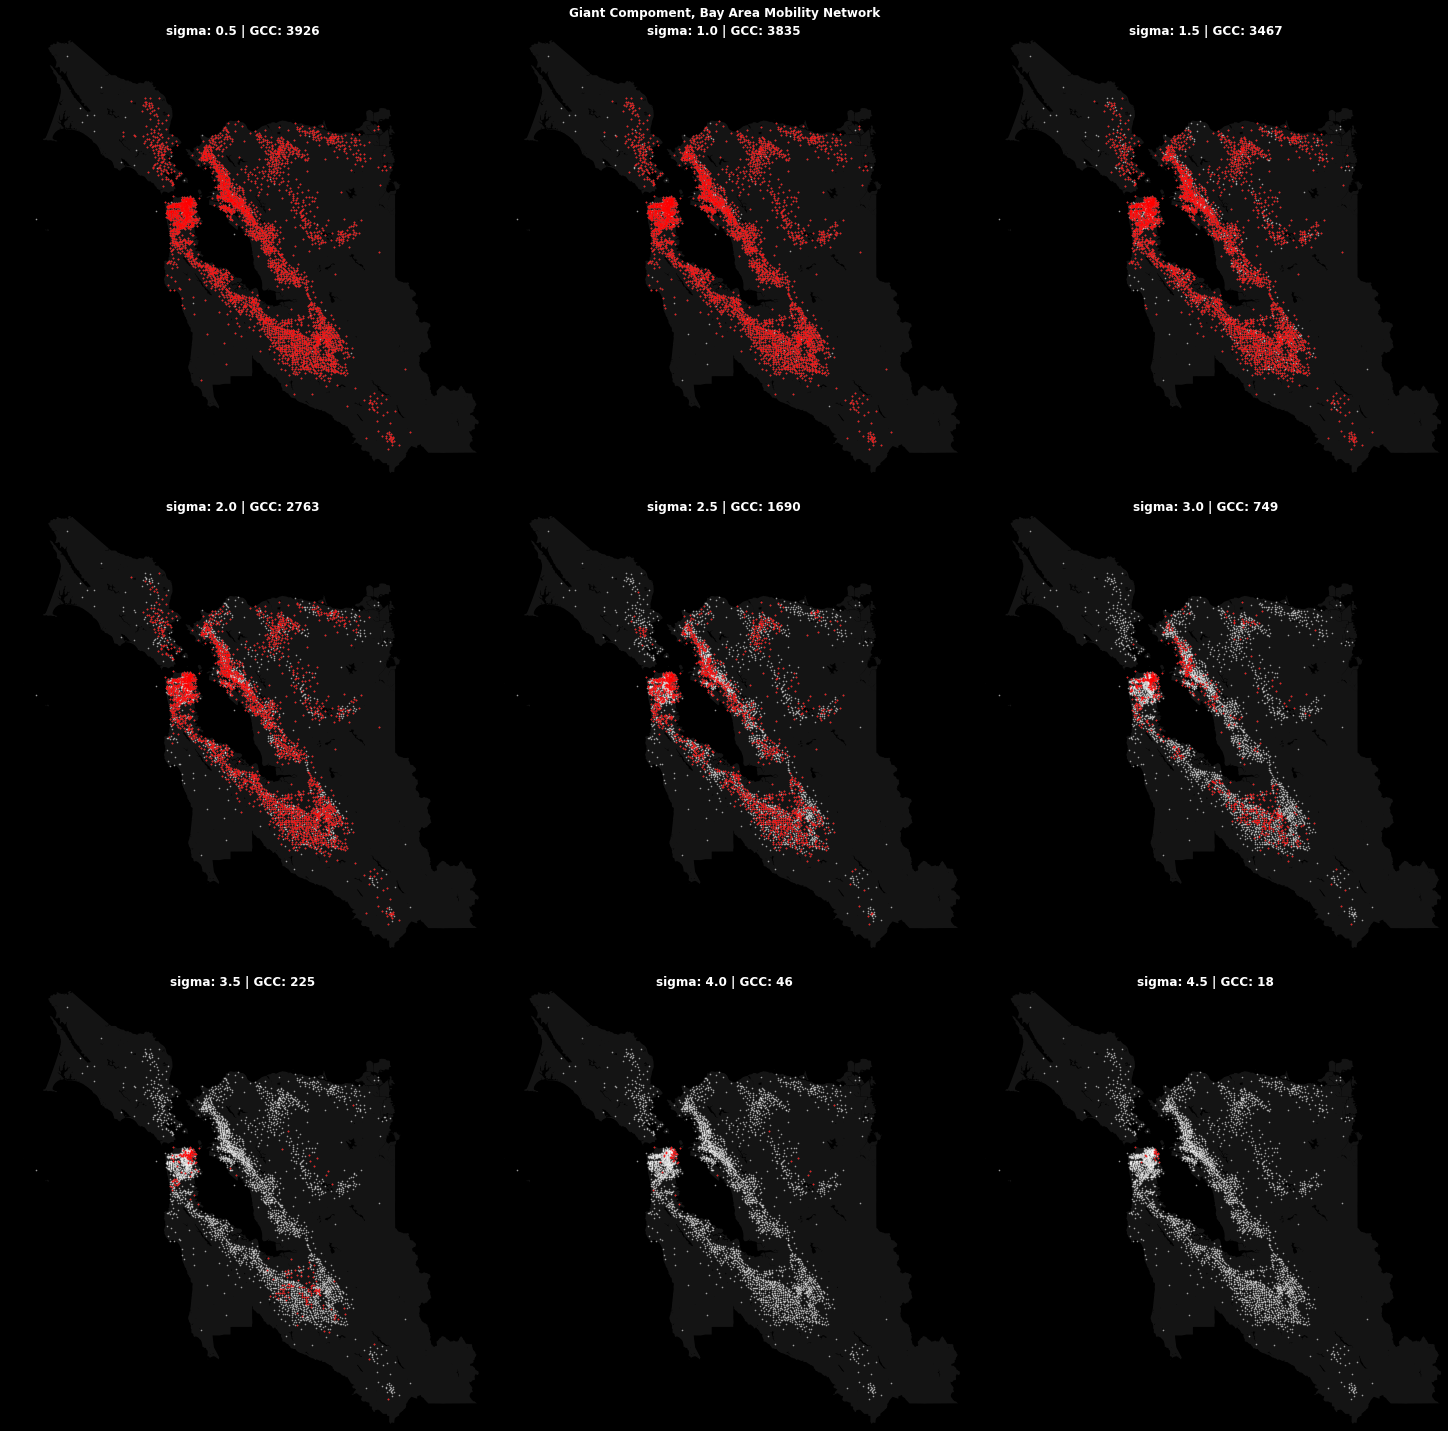

In [309]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20), 
                       facecolor='k',
                       constrained_layout=True, 
                       subplot_kw=dict(aspect='equal'))

axs = axs.ravel()

t = np.arange(0.5, 5, 0.5)

for i in np.arange(0, 9):
    
    print(i)
    
    temp = zscoring[zscoring.zscore_d > (zscoring.lognij_d_std * i)]
    G = nx.from_pandas_edgelist(temp, source='src', target='trg', edge_attr = 'nij')
    gcc = max(nx.connected_components(G), key=len)
    cbg = nodes[nodes.GEOID.isin(gcc)]
    gdf = gpd.GeoDataFrame(cbg, geometry=gpd.points_from_xy(cbg.X, cbg.Y))
    
    background.plot(color='dimgray', ax=axs[i], alpha=0.2)
    
    gpd.GeoDataFrame(nodes, geometry=gpd.points_from_xy(nodes.X, nodes.Y)).plot(color='white', ax=axs[i], markersize=0.5, alpha=0.5)
    gdf.plot(color='red', ax=axs[i], markersize=0.7, alpha=0.7)

    axs[i].margins(0)
    axs[i].axis('off')
    
    axs[i].set_title(f"sigma: {t[i]} | GCC: {len(gcc)}", color='w', weight='bold')

fig.suptitle("Giant Compoment, Bay Area Mobility Network", color='white', weight='bold')
fig.savefig('backbone_gcc.png', facecolor=fig.get_facecolor(), dpi=300, bbox_inches='tight')